## FinBERT Sentiment Analysis

#### Import Packages

In [28]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"    # avoid TF backend import
os.environ["TRANSFORMERS_NO_FLAX"] = "1"  # avoid Flax


#### FinBERT Model Setup

In [29]:

MODEL = "ProsusAI/finbert"

if "model" not in globals():
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(DEVICE).eval()
    print(f"Loaded FinBERT on {DEVICE}.")
else:
    # (optional) if CUDA becomes available later, move it
    new_device = "cuda" if torch.cuda.is_available() else "cpu"
    if str(next(model.parameters()).device) != new_device:
        model.to(new_device).eval()
        DEVICE = new_device
        print(f"Moved model to {DEVICE}.")
    else:
        print("Model already loaded; skipping.")


Model already loaded; skipping.


In [34]:
def finbert_proba(texts, batch_size=32, device=DEVICE, max_length=256):
    """Return a list of dicts: [{'negative': p, 'neutral': p, 'positive': p}, ...]"""
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            ).to(device)
            logits = model(**enc).logits
            probs = F.softmax(logits, dim=-1).cpu().tolist()
            for p in probs:
                # map indices -> labels dict
                out = {id2label[j]: float(p[j]) for j in range(len(p))}
                # ensure all three keys exist
                for k in ("negative", "neutral", "positive"):
                    out.setdefault(k, 0.0)
                all_probs.append(out)
    return all_probs

def sentiment_label(texts, neutrality_threshold=1):
    """
    Map each text to 'positive'/'negative'/'neutral' after thresholding.
    """
    probs = finbert_proba(texts)
    labels = []
    for p in probs:
        if p["neutral"] >= neutrality_threshold:
            labels.append("neutral")
        else:
            labels.append("positive" if p["positive"] > p["negative"] else "negative")
    return labels

def top2_margin(p: dict) -> float:
    """Return max_prob - second_prob in [0,1]. p has keys 'negative','neutral','positive'."""
    vals = sorted([p["negative"], p["neutral"], p["positive"]], reverse=True)
    return float(vals[0] - vals[1])

def sentiment_score(texts):
    """
    Continuous score per text: 0 if too neutral (currently 100% neutral or pos = neg), else (pos - neg).
    Useful for weighting by Reddit score later.
    """
    probs = finbert_proba(texts)
    scores = []
    for p in probs:
        base = (p["positive"] - p["negative"])           
        neutral_damp = (1.0 - p["neutral"])              
        margin_damp = top2_margin(p)                           
        scores.append(base * neutral_damp * margin_damp)
    return scores

def tanh_scale_series(scores, k=None, percentile=95):
    s = np.asarray(scores, dtype=float)
    s = np.nan_to_num(s, nan=0.0)
    if k is None:
        # choose a robust scale from your own data
        P = np.percentile(np.abs(s), percentile) if s.size else 1.0
        k = max(P, 1.0)
    w = np.tanh(s / k)  # w in [-1, 1], sign preserved
    return w, float(k)

# def score_multiplier(raw_sentiment_scores, reddit_scores):
#     """
#     Multiplies score per text by their Reddit score (Upvotes-Downvotes). without Tanh scaling.
#     """
#     scaled_reddit_scores = reddit_scores * w
#     for i in range(len(raw_sentiment_scores)):
#         scaled_sentiment_scores.append(raw_sentiment_scores[i] * scaled_reddit_scores[i])
#     return scaled_sentiment_scores

def score_multiplier(raw_sentiment_scores, reddit_scores, percentile=95):
    """
    raw_sentiment_scores: list/array of sentiment scores in [-1, 1]
    reddit_scores: list/array of signed Reddit scores (ups - downs)
    returns: list of crowd-adjusted scores in [-1, 1]
    """
    rs = np.asarray(raw_sentiment_scores, dtype=float)
    w, k_used = tanh_scale_series(reddit_scores, percentile=percentile)
    # elementwise combine; DO NOT multiply by raw reddit_scores again
    return (rs * w).tolist(), k_used


In [35]:

# Example
# texts = ["Seems like this will be the last profitable quarter for Tesla"]
# upvotes = [1000]
# probs = finbert_proba(texts)
# print("probs:", probs[0])
# print("label:", sentiment_label(texts)[0])
# print("raw score:", sentiment_score(texts)[0])
# print("scaled score:", score_multiplier(sentiment_score(texts), upvotes)[0])

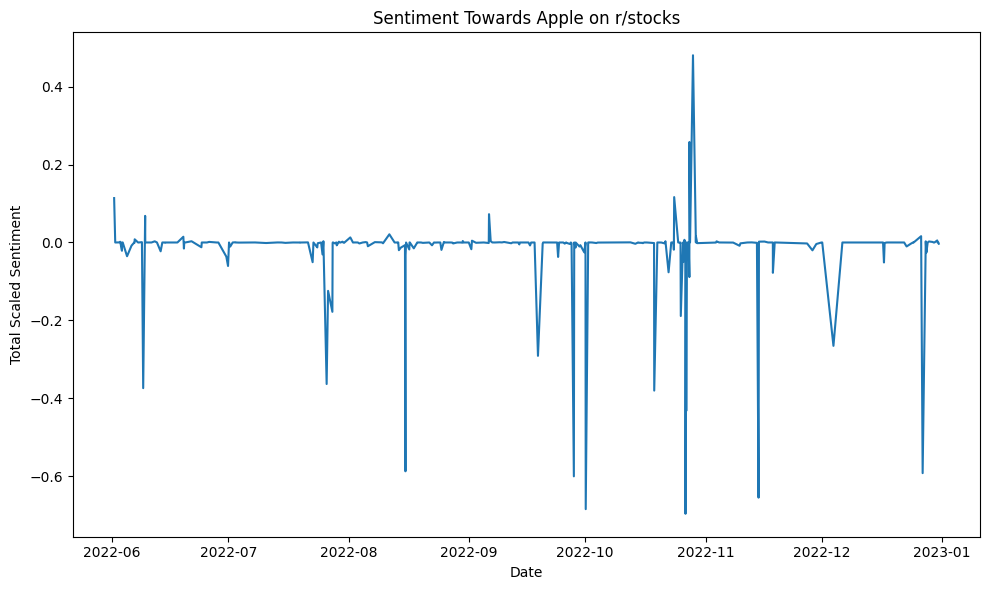

In [ ]:
# proper, multiple datasets lines below
# file_locations ={"Amazon" : r"C:\Users\ftomi\Documents\GitHub\NLP-Group-10\companies_csv\Amazon_submissions.csv", 
#                  "Apple" : r"C:\Users\ftomi\Documents\GitHub\NLP-Group-10\companies_csv\Apple_submissions.csv", 
#                  "Tesla" : r"C:\Users\ftomi\Documents\GitHub\NLP-Group-10\companies_csv\Tesla_submissions.csv"} 

# singular test line below
file_locations = {"Apple" : r"C:\Users\ftomi\Documents\GitHub\NLP-Group-10\companies_csv\Apple_submissions.csv"}

for fl in file_locations:

    df = pd.read_csv(file_locations[fl])

    dates = []
    texts = []
    upvotes = [] 
    scaled_sentiment_scores = []
    raw_sentiment_scores = []

    data = df.to_dict('index')
    for i in range(len(data)):
        texts.append(data[i]['selftext'])
        dates.append(datetime.fromtimestamp(data[i]['created_utc'], tz=timezone.utc))
        upvotes.append(data[i]['score'])

    probs = finbert_proba(texts)
    raw_sentiment_scores = sentiment_score(texts)
    scaled_sentiment_scores, k_used = score_multiplier(sentiment_score(texts), upvotes)
    
    # save as dataframe
    sentiment_df = pd.DataFrame(dict(scaled_sentiment = scaled_sentiment_scores, created_utc = dates))
    sentiment_df.to_csv(f"{fl}_sentiment_data.csv", index=False)

    #show and save figure
    plt.figure(figsize=(10,6))
    plt.plot(dates, raw_sentiment_scores, label = "raw",  linestyle=":", linewidth=0.8)
    plt.plot(dates, scaled_sentiment_scores, label = "scaled by reddit score")
    plt.title(f"Sentiment Towards {fl} on r/stocks")
    plt.xlabel("Date")
    plt.ylabel("Total Sentiment")
    plt.tight_layout()
    plt.grid()
    plt.savefig(f"{fl}_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

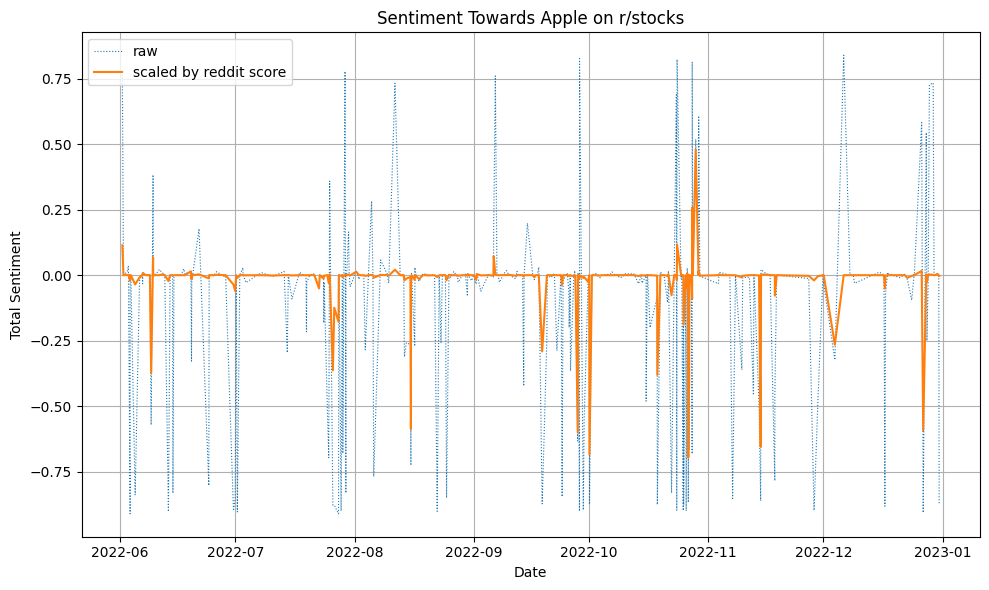

In [45]:
#show and save figure
plt.figure(figsize=(10,6))
plt.plot(dates, raw_sentiment_scores, label = "raw",  linestyle=":", linewidth=0.8)
plt.plot(dates, scaled_sentiment_scores, label = "scaled by reddit score")
plt.title(f"Sentiment Towards {fl} on r/stocks")
plt.xlabel("Date")
plt.ylabel("Total Sentiment")
plt.tight_layout()
plt.grid()
plt.legend()
plt.savefig(f"{fl}_plot.png", dpi=300, bbox_inches="tight")
plt.show()